In [17]:
import pandas as pd


In [18]:
df_clean = pd.read_csv("combined_esg_final.csv")
df_clean.head()

,category,company,env_relevant,has_metric,sentence,source_file,year
0,vision,AMERICAN-FOREST-PAPER-ASSOCIATION_ESG,True,False,Member efforts to increase efficiencies and fu...,american-forest-paper-association_2016_esg.jsonl,2016
1,metric,AMERICAN-FOREST-PAPER-ASSOCIATION_ESG,True,True,2 ENERGY EFFICIENCY At least a 10 percent incr...,american-forest-paper-association_2016_esg.jsonl,2016
2,other,AMERICAN-FOREST-PAPER-ASSOCIATION_ESG,True,False,It has enabled the mill to put net power to th...,american-forest-paper-association_2016_esg.jsonl,2016
3,metric,AMERICAN-FOREST-PAPER-ASSOCIATION_ESG,False,True,The amount of wood fiber members procured from...,american-forest-paper-association_2016_esg.jsonl,2016
4,metric,AMERICAN-FOREST-PAPER-ASSOCIATION_ESG,False,True,WOOD FIBER PROCURED FROM CERTIFIED FIBER SOURC...,american-forest-paper-association_2016_esg.jsonl,2016


In [19]:
df_clean['sentence'].iloc[1]

'2 ENERGY EFFICIENCY At least a 10 percent increase in members’ purchased energy efficiency from 2005 to 2020 Member purchased energy use per ton of production was 8.1 percent lower in 2014 2015 LEADERSHIP IN SUSTAINABILITY AWARD FOR ENERGY EFFICIENCY / GREENHOUSE GAS compared to the baseline year of 2005.'

In [20]:
df_clean.shape

(1264, 7)

In [21]:
df_clean['category'].value_counts()

category
other         616
vision        319
metric        190
governance     79
action         50
marketing      10
Name: count, dtype: int64

In [22]:
import re

def is_valid_sentence(s):
    s = s.strip()
    if len(s.split()) < 6:
        return False
    if s.isupper():
        return False
    if re.fullmatch(r'[\d\W]+', s):
        return False
    return True

df_clean = df_clean[df_clean['sentence'].apply(is_valid_sentence)]
df_clean.reset_index(drop=True, inplace=True)
df_clean.shape

(1239, 7)

In [23]:
def weak_greenwashing_label(row):
    if row['category'] == 'vision' and not row['has_metric']:
        return 2
    if row['category'] == 'action' and not row['has_metric']:
        return 1
    if row['category'] == 'metric' and row['has_metric']:
        return 0
    return 0

df_clean['gw_label'] = df_clean.apply(weak_greenwashing_label, axis=1)


In [24]:
df_clean.sample(100, random_state=42)[
    ['sentence', 'category', 'has_metric', 'gw_label']
]


,sentence,category,has_metric,gw_label
415,"SUPPORT EACH OTHER However, at some of Murphy’...",other,False,0
259,Boeing established 2030 environmental Operatio...,vision,False,2
332,"to use more sustainable packaging, we intend t...",other,False,0
621,These groups include the Offshore Operators Co...,governance,False,0
101,Using Carbon Dioxide (CO ) as a recyclable res...,other,False,0
...,...,...,...,...
328,We plan to have our reduction goal target all ...,vision,False,2
23,"Therefore, members con- of water consumption, ...",other,False,0
1202,- - - 869 520 12.c Employee Turnover Rate (Inc...,other,False,0
290,Air Transport Action Group analysis Each new g...,other,False,0


In [25]:
df_clean['gw_label'].value_counts(normalize=True)


gw_label
0    0.702986
2    0.256659
1    0.040355
Name: proportion, dtype: float64

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

X = df_clean['sentence']
y = df_clean['gw_label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

vectorizer = TfidfVectorizer(
    max_features=8000,
    ngram_range=(1,2),
    stop_words='english'
)

X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

model = LogisticRegression(class_weight='balanced', max_iter=1000)
model.fit(X_train_vec, y_train)

y_pred = model.predict(X_test_vec)

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.88      0.90      0.89       174
           1       0.80      0.40      0.53        10
           2       0.75      0.75      0.75        64

    accuracy                           0.84       248
   macro avg       0.81      0.68      0.72       248
weighted avg       0.84      0.84      0.84       248



In [27]:
test_df = X_test.copy()
test_df = test_df.to_frame(name="sentence")
test_df["true"] = y_test.values
test_df["pred"] = y_pred

# Focus on greenwashing confusions
test_df[(test_df.true == 2) & (test_df.pred != 2)].head(10)


,sentence,true,pred
807,The duration of the training We are aiming to ...,2,0
1034,At the biodiverse areas within helps to determ...,2,0
1190,taxation policies with its commitment to a rob...,2,0
1188,This collaboration developed by Prof Robert S ...,2,0
495,We undertake We use the World Resource Institu...,2,0
545,We • Utilizing forward-looking infrared (FLIR)...,2,0
764,"In similar vein, Our Energy and Carbon Managem...",2,0
629,Conducting technology trials of new produced w...,2,0
461,The dual-fuel fleet partially our Company’s go...,2,0
645,"The Operations Sustainability Focus Team, comp...",2,0


In [28]:
fn = test_df[(test_df.true == 2) & (test_df.pred != 2)]
fn[['sentence']]

,sentence
807,The duration of the training We are aiming to ...
1034,At the biodiverse areas within helps to determ...
1190,taxation policies with its commitment to a rob...
1188,This collaboration developed by Prof Robert S ...
495,We undertake We use the World Resource Institu...
545,We • Utilizing forward-looking infrared (FLIR)...
764,"In similar vein, Our Energy and Carbon Managem..."
629,Conducting technology trials of new produced w...
461,The dual-fuel fleet partially our Company’s go...
645,"The Operations Sustainability Focus Team, comp..."


In [29]:
confused = test_df[
    ((test_df.true == 1) & (test_df.pred == 2)) |
    ((test_df.true == 2) & (test_df.pred == 1))
]
confused[['sentence']].head(10)


,sentence


In [30]:
import pandas as pd

test_df = pd.DataFrame({
    "sentence": X_test.values,
    "true": y_test.values,
    "pred": y_pred
})


In [31]:
fn = test_df[(test_df.true == 2) & (test_df.pred != 2)]
fn.head(10)


,sentence,true,pred
7,The duration of the training We are aiming to ...,2,0
33,At the biodiverse areas within helps to determ...,2,0
43,taxation policies with its commitment to a rob...,2,0
49,This collaboration developed by Prof Robert S ...,2,0
65,We undertake We use the World Resource Institu...,2,0
87,We • Utilizing forward-looking infrared (FLIR)...,2,0
101,"In similar vein, Our Energy and Carbon Managem...",2,0
129,Conducting technology trials of new produced w...,2,0
159,The dual-fuel fleet partially our Company’s go...,2,0
161,"The Operations Sustainability Focus Team, comp...",2,0


In [32]:
FUTURE_WORDS = [
    "will", "aim", "plan", "target", "aspire", "commit",
    "endeavour", "seek", "intends"
]

VAGUE_WORDS = [
    "significant", "leading", "robust", "strong",
    "substantial", "enhanced", "improved", "responsible"
]


In [33]:
def count_words(sentence, word_list):
    s = sentence.lower()
    return sum(s.count(w) for w in word_list)

df_clean["future_count"] = df_clean["sentence"].apply(
    lambda x: count_words(x, FUTURE_WORDS)
)

df_clean["vague_count"] = df_clean["sentence"].apply(
    lambda x: count_words(x, VAGUE_WORDS)
)


In [34]:
from scipy.sparse import hstack

X_text = df_clean["sentence"]
y = df_clean["gw_label"]

X_train, X_test, y_train, y_test = train_test_split(
    X_text, y, test_size=0.2, stratify=y, random_state=42
)

tfidf = TfidfVectorizer(
    max_features=8000,
    ngram_range=(1,2),
    stop_words="english"
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

extra_train = (
    df_clean
    .loc[X_train.index, ["future_count", "vague_count", "has_metric"]]
    .astype(float)
    .values
)

extra_test = (
    df_clean
    .loc[X_test.index, ["future_count", "vague_count", "has_metric"]]
    .astype(float)
    .values
)


X_train_final = hstack([X_train_tfidf, extra_train])
X_test_final = hstack([X_test_tfidf, extra_test])


In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

model = LogisticRegression(
    class_weight="balanced",
    max_iter=2000
)

model.fit(X_train_final, y_train)
y_pred = model.predict(X_test_final)

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.92      0.83      0.87       174
           1       0.71      0.50      0.59        10
           2       0.64      0.83      0.72        64

    accuracy                           0.82       248
   macro avg       0.76      0.72      0.73       248
weighted avg       0.84      0.82      0.82       248



In [36]:
df_clean["gw_binary"] = df_clean["gw_label"].apply(
    lambda x: 1 if x == 2 else 0
)


In [37]:
X = df_clean["sentence"]
y = df_clean["gw_binary"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

X_train_vec = tfidf.fit_transform(X_train)
X_test_vec = tfidf.transform(X_test)

model_bin = LogisticRegression(
    class_weight="balanced",
    max_iter=2000
)

model_bin.fit(X_train_vec, y_train)
y_pred_bin = model_bin.predict(X_test_vec)

print(classification_report(y_test, y_pred_bin))


              precision    recall  f1-score   support

           0       0.92      0.90      0.91       184
           1       0.72      0.78      0.75        64

    accuracy                           0.87       248
   macro avg       0.82      0.84      0.83       248
weighted avg       0.87      0.87      0.87       248



In [38]:
from sentence_transformers import SentenceTransformer

sbert = SentenceTransformer("all-MiniLM-L6-v2")

embeddings = sbert.encode(
    df_clean["sentence"].tolist(),
    show_progress_bar=True
)


Loading weights: 100%|██████████| 103/103 [00:00<00:00, 309.69it/s, Materializing param=pooler.dense.weight]                             
BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
Batches: 100%|██████████| 39/39 [00:06<00:00,  5.62it/s]


In [39]:
from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train, y_test = train_test_split(
    embeddings, df_clean["gw_binary"],
    test_size=0.2, stratify=df_clean["gw_binary"], random_state=42
)

clf = LogisticRegression(
    class_weight="balanced",
    max_iter=2000
)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.89      0.83      0.86       184
           1       0.60      0.72      0.65        64

    accuracy                           0.80       248
   macro avg       0.75      0.78      0.76       248
weighted avg       0.82      0.80      0.81       248



In [40]:
df_clean["gw_pred"] = model_bin.predict(
    tfidf.transform(df_clean["sentence"])
)

company_risk = (
    df_clean
    .groupby(["company", "year"])
    .gw_pred
    .mean()
    .reset_index(name="greenwashing_ratio")
)


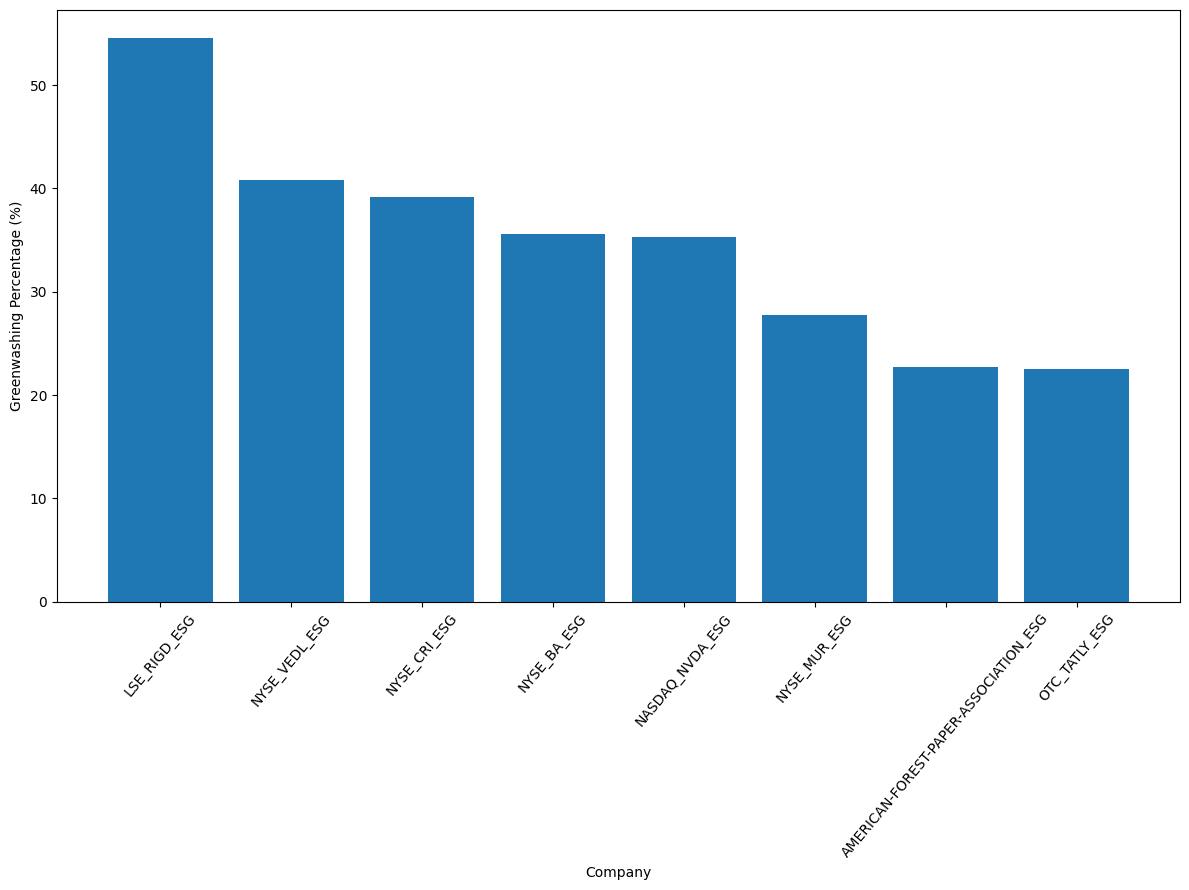

In [46]:
import matplotlib.pyplot as plt

# Convert ratio to percentage
company_risk["greenwashing_pct"] = company_risk["greenwashing_ratio"] * 100

# Sort companies by greenwashing percentage
viz_df = company_risk.sort_values("greenwashing_pct", ascending=False)

plt.figure(figsize=(12, 9))
plt.bar(viz_df["company"], viz_df["greenwashing_pct"])
plt.xlabel("Company")
plt.ylabel("Greenwashing Percentage (%)")
# plt.title("Greenwashing Percentage by Company")
plt.xticks(rotation=50)
plt.tight_layout()
plt.show()


In [28]:
sbert.save_pretrained("greenwashing_app/model/bert_greenwashing")
# Tokenizer is already saved with the model, no need to save separately


Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  7.80it/s]


In [1]:
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments
)
import torch


c:\Greenwashing\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import pandas as pd

df = pd.read_csv("combined_esg_final.csv")

def assign_label(category):
    if category in ["marketing", "vision"]:
        return 1   # greenwashing-prone
    else:
        return 0   # substantiated

df["label"] = df["category"].apply(assign_label)

# sanity check
print(df["label"].value_counts())

df.to_csv("combined_esg_labeled.csv", index=False)


label
0    935
1    329
Name: count, dtype: int64


In [14]:
df = pd.read_csv("combined_esg_labeled.csv")

df = df[["sentence", "label"]]

df = df.dropna()

df.head()

,sentence,label
0,Member efforts to increase efficiencies and fu...,1
1,2 ENERGY EFFICIENCY At least a 10 percent incr...,0
2,It has enabled the mill to put net power to th...,0
3,The amount of wood fiber members procured from...,0
4,WOOD FIBER PROCURED FROM CERTIFIED FIBER SOURC...,0


In [4]:
MODEL_NAME = "bert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2
)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)


Loading weights: 100%|██████████| 199/199 [00:00<00:00, 380.06it/s, Materializing param=bert.pooler.dense.weight]                               
BertForSequenceClassification LOAD REPORT from: bert-base-uncased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
classifier.weight                          | MISSING    | 
classifier.bias                            | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those pa

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [7]:
from datasets import Dataset

dataset = Dataset.from_pandas(df)

def tokenize(batch):
    return tokenizer(
        batch["sentence"],
        truncation=True,
        padding="max_length",
        max_length=256
    )

dataset = dataset.map(tokenize, batched=True)
dataset = dataset.train_test_split(test_size=0.2)

dataset.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "label"]
)


Map: 100%|██████████| 1264/1264 [00:00<00:00, 6105.69 examples/s]


In [9]:
from transformers import TrainingArguments
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    logging_steps=50,
)


In [11]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
)


In [12]:
trainer.train()


c:\Greenwashing\venv\Lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

In [ ]:
SAVE_PATH = "greenwashing_app/model/bert_greenwashing"

model.save_pretrained(SAVE_PATH)
tokenizer.save_pretrained(SAVE_PATH)
